In [1]:
import sys
sys.path.append("/glade/work/zhixing/python_scripts/SOM-SEASONAL/User-defined/")  ## import some self-defined functions
from Synoptic_regimes import *

In [2]:
# #-- read ERA5 reanalysis data
#-#
map_data_700, tod_map_hgt_700, precip, uwind_700, vwind_700, temp_700, IVMFT_u, IVMFT_v,  lat_era5, lon_era5 = read_ERA5_data()

#------------------------------------------------------------------------------------------------------------------------------------------------
## map_data_700: the geopotential height at 700 mb; [time_dim, lat_dim, lon_dim]                                                                \\
## tod_map_hgt_700: the reshaped array by map_data_700.reshape(time_dim, lat_dim * lon_dim)                                                     \\
## precip: precipitation | uwind_700: horizontal wind at 700 mb | vwind_700: meridional wind at 700 mb | temp_700: temperature at 700 mb        \\
## IVMFT_u: integrated water vapor flux at horizontal direction | IVMFT_v: integrated water vapor flux at meridional direction                  \\
## lat_era5 & lon_era5: the coordinate of ERA5 data (resolution 0.25 degree * 0.25 degree)                                                      \\
#------------------------------------------------------------------------------------------------------------------------------------------------

# #-- read the processed wrf output for accumulated snow/precipitation data (SNOWNC/ RAINNC)
#-#
rain, time, lons_wrf, lats_wrf = extract_wrf_rainnc_data(variable = 'precipitation') ## extract the hourly precip from WRF output
snow, time, lons_wrf, lats_wrf = extract_wrf_rainnc_data(variable = 'snow')

## rain: hourly precipitation (accumulated grid-scale precipitation --> Rain_t1 - Rain_t0 --> precip rate)
## snow: hourly snow (accumulated grid-scale snow and ice; primarily (snow)--> Snow_t1 - Snow_t0 --> Snowfall rate)

In [3]:
NODE1_NUM = 2; NODE2_NUM = 2 ## Here, we used 2 * 2 structure to construct SOM model

# #-- running the self-organizing map, get the cluster results for each map
#-#
# w_x, w_y = SOM_processing(NODE1 = NODE1_NUM , NODE2 = NODE2_NUM , sigma = 1.1, l_r = 0.4, n_f = 'gaussian',r_s = 59, iterations=400, max_iter=1000)
## !! here we already set the input data size legnth as the length of the time_dim of tod_map_hgt_700
#--------------------------------------------------------------------------------------------------------------------------------------------------------
## NODE1 & NODE2: the node number of SOM in its first and second dimension (define its size)                                                            \\
## sigma: the neighborhood radius                                                                                                                       \\
## l_r: the learning rate                                                                                                                               \\
## n_f: the neighborhood_function                                                                                                                       \\
## r_s: the random seed number                                                                                                                          \\
## iterations: If use_epochs is False, the weights will be updated num_iteration times. Otherwise they will be updated len(data)*num_iteration times.   \\
## If use_epochs is True:Number of epochs the SOM will be trained for. If use_epochs is False: Maximum number of iterations (one iteration per sample)  \\
## max_iter: the index of current pattern (for calculating the decay rate of sigma and learning rate)                                                   \\
#--------------------------------------------------------------------------------------------------------------------------------------------------------


w_x = np.load('/glade/work/zhixing/python_scripts/temp_w_x.npy')  ## the x-position for each pattern
w_y = np.load('/glade/work/zhixing/python_scripts/temp_w_y.npy')  ## the y-position for each pattern


# #-- get the index for each node
#-#
dic_cluster, dic_time = Link_processing(NODE1=NODE1_NUM , NODE2 = NODE2_NUM, w_x = w_x, w_y = w_y, time = time)
## dic_cluster: the indexes for each pattern in each category. e.g. {(0,0):[x1,x2,x3,x4,x5]} means the patterns associated with node (0,0)

# #-- Count the numbers of maps in each node
Count_processing(NODE1=NODE1_NUM , NODE2=NODE2_NUM , dic_cluster = dic_cluster) ## print the information about how many maps we have in each node


# #-- After self-organizing map clustering these maps, filter out the "little precipitation maps"
## the idea is to eliminate little precip maps. But how to settle down a threshold value in different synoptic conditions is a tricky problem
## If we choose to use percentile, it seems like this problem has been resolved. 
## But the whole idea for this article is that if we can look at (or say forecast) synoptic circulation and infer corresponding precipitation patterns (where they concentrated most likely)
## And then go deeper to analyze its spatial ice/supercooled water path, profiles of different hydrometeors...
## So, here we want to keep the data as original as possible to avoid mannual-induced biases. Thus, this function has not been applied. (But if we focus on extreme precip events, maybe it's a different story) 
# filter_dic_cluster = get_filter_dic_cluster(var=rain, dic_cluster=dic_cluster, threshold = 0.1) # this is a threshold value
# Count_processing(NODE1=NODE1_NUM , NODE2=NODE2_NUM , dic_cluster = filter_dic_cluster)

# #-- get ERA5 data
## get the geopotential height, temperature, horizontal winds, and meridional winds at 700hPa (ERA5 data).
## get the integrated water vapor transportation and ground precipitation (ERA5 data).
dic_hgt_700_ERA5_map , dic_temp_700_ERA5_map, dic_u_700_ERA5_map, dic_v_700_ERA5_map, dic_IVMFT_u_ERA5_map, dic_IVMFT_v_ERA5_map,  dic_pcp_ERA5_map\
= Plot_ERA5_data_preprocessing(dic_cluster=dic_cluster, geo_ht=map_data_700, temp=temp_700,\
                               ua=uwind_700, va=vwind_700, ivt_u=IVMFT_u, ivt_v=IVMFT_v, precip=precip)


Link data with cluster	 Finished...

position:  (0, 0) 	 461
position:  (0, 1) 	 500
position:  (1, 0) 	 648
position:  (1, 1) 	 551


Idaho State Found!


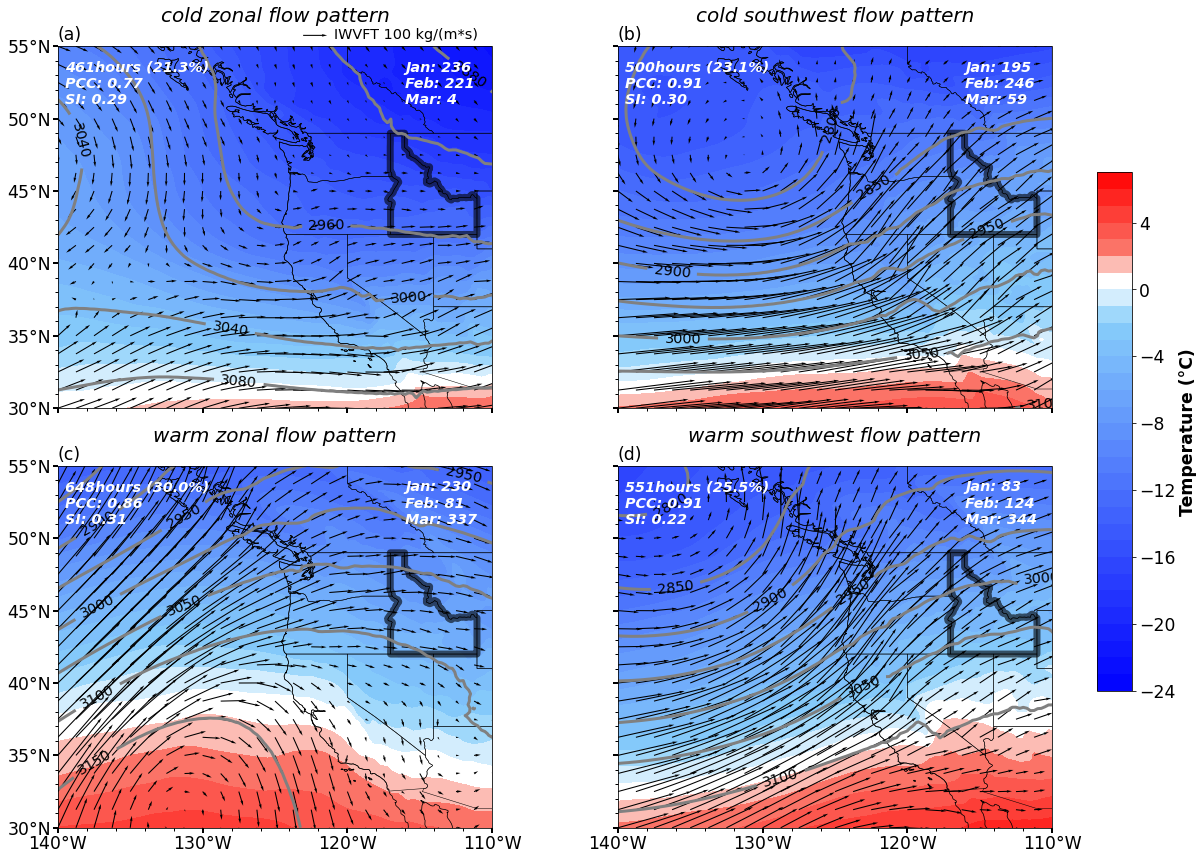

In [6]:
from matplotlib.colors import LinearSegmentedColormap

xx, yy = np.meshgrid(lon_era5,lat_era5)  ## construct 2d meshgrid for plotting 
dataproj = ccrs.PlateCarree() ; plotproj  = ccrs.PlateCarree() ## select projection 
## create the colormaps manually
cMap = []
for value, colour in zip([0,22,24.5,25,26,31],["Blue","lightskyblue","white","white","salmon","red"]):
    cMap.append((value/31, colour))
customColourMap2 = LinearSegmentedColormap.from_list("custom", cMap)

fig, axs = plt.subplots(2,2,figsize=(16, 12), subplot_kw = {'projection':plotproj}, sharex=True, sharey=True)

## load the shapefile of Idaho State
for state in shapereader.Reader("/glade/u/home/zhixing/ShapeFile/admin_1_province_country_10m/ne_10m_admin_1_states_provinces.shp").records():
    if state.attributes['name_id'] == 'Idaho': ## if we found the Idaho state, print out the message  
        Idaho = state.geometry
        print("Idaho State Found!")
        break
else:
    raise ValueError('Unable to find the Idaho boundary.')
    
title_list = [['cold zonal flow pattern', 'cold southwest flow pattern'], ['warm zonal flow pattern','warm southwest flow pattern']]
alpha_list = [['(a)', '(b)'], ['(c)', '(d)']]

for i in range(2):
    for j in range(2):
        axs[i,j].coastlines('50m', linewidth=0.75)
        axs[i,j].add_feature(cfeature.STATES, linewidth=0.5) ## add the features of States
        axs[i,j].set_extent([-140, -110, 30, 55],ccrs.PlateCarree()) ## set the content of map
        axs[i,j].add_geometries([Idaho], ccrs.Geodetic(), edgecolor='k', ## add a thick line encompassing the boarder of Idaho
                          facecolor='none', linewidth=7, alpha = 0.6)
        
        ## plot the temperature contour
        data = dic_temp_700_ERA5_map[(i,j)] - 273.15 ## K convert into degree celcius
        lvls = np.arange(-24, 8) ## the contour levels of temperature
        #customColourMap; cmaps.MPL_coolwarm
        cf_tem  = axs[i,j].contourf(xx, yy, data, transform=dataproj, cmap=customColourMap2, levels = lvls)

        ## plot the IVMFT fields
        u_data = dic_IVMFT_u_ERA5_map[(i,j)]  ## the horizontal integrated water vapor flux 
        v_data = dic_IVMFT_v_ERA5_map[(i,j)]  ## the meridional integrated water vapor flux
        wind_slice = (slice(None, None, 5), slice(None, None, 5))
        wind_barb = axs[i,j].quiver(xx[wind_slice], yy[wind_slice],u_data[wind_slice], v_data[wind_slice], color='black', transform=dataproj, scale_units='inches', scale = 300, headwidth=2.5 ) ## the wind barb
        if i==0 and j==0:
            qk = axs[i,j].quiverkey(wind_barb, 0.62, 1.03, 100, r'IWVFT 100 kg/(m*s)', labelpos='E',
                               coordinates='axes', fontproperties={'size':'x-large'})  ## the icon of wind barb
                
        ## geopotential height at 700 mb
        data = dic_hgt_700_ERA5_map[(i,j)]  
        cl_level  = axs[i,j].contour(xx, yy, data, colors="gray", transform = dataproj, linewidths = 3, inline=False)  ## plot the lines of geopotential height
        axs[i,j].clabel(cl_level, fmt="%i", fontsize = 'x-large', colors = 'k')
        k = i*2 + j + 1
        axs[i,j].set_title("Node " + str(k), fontsize = 'x-large')
        # counts = len(dic_cluster[(i,j)]); fraction = round(counts*100 / 2160, 1)
        axs[i,j].set_title(loc='left', label=alpha_list[i][j], fontsize = 'xx-large')  ## set the title of each pattern
        axs[i,j].set_title(title_list[i][j], fontsize=20, y=1.05, fontstyle='italic')
        
        axs[i,j].set_xticks([-140, -130, -120, -110], crs=ccrs.PlateCarree()) ## set the labels of xticks
        axs[i,j].set_yticks([30, 35, 40, 45, 50, 55], crs=ccrs.PlateCarree()) ## set the labels of yticks
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                           dateline_direction_label=True)  ## the format of longitude
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                          degree_symbol='°')
        axs[i,j].xaxis.set_major_formatter(lon_formatter)
        axs[i,j].yaxis.set_major_formatter(lat_formatter)
        axs[i,j].xaxis.set_minor_locator(ticker.AutoMinorLocator())
        axs[i,j].yaxis.set_minor_locator(MultipleLocator(1))
        axs[i,j].tick_params(which='major',labelsize='xx-large', width=2, length=5,  pad=2) ## set the parameters of ticks
        axs[i,j].tick_params(which='minor',labelsize='small', width=1, length=3,  pad=1)


# fig.suptitle(t = "700 hPa", x = 0.5, y = 0.98, fontsize = 'x-large', fontweight = 'bold', fontstyle = 'italic')

#--- add figure color bar
cax  = plt.axes([0.98, 0.2, 0.03, 0.6]) ## add the location of colorbar
cbar = plt.colorbar(cf_tem, cax=cax,shrink=0.8,ticklocation='right')
cbar.ax.tick_params(labelsize='xx-large') 
cbar.set_label(label='Temperature (\u00b0C)', weight='bold', fontsize='xx-large')

#--- add annotation

axs[0,0].text(-139.5, 51, '461hours (21.3%)\nPCC: 0.77\nSI: 0.29', style='italic', color='white', fontweight = 'bold',
        transform = dataproj, fontsize = 'x-large',zorder=10)
axs[0,0].text(-116, 51, 'Jan: 236\nFeb: 221\nMar: 4', style='italic', color='white', fontweight = 'bold',
        transform = dataproj, fontsize = 'x-large',zorder=10)
axs[0,1].text(-139.5, 51, '500hours (23.1%)\nPCC: 0.91\nSI: 0.30', style='italic', color='white', fontweight = 'bold',
        transform = dataproj, fontsize = 'x-large',zorder=10)
axs[0,1].text(-116, 51, 'Jan: 195\nFeb: 246\nMar: 59', style='italic', color='white', fontweight = 'bold',
        transform = dataproj, fontsize = 'x-large',zorder=10)
axs[1,0].text(-139.5, 51, '648hours (30.0%)\nPCC: 0.86\nSI: 0.31', style='italic', color='white', fontweight = 'bold',
        transform = dataproj, fontsize = 'x-large',zorder=10)
axs[1,0].text(-116, 51, 'Jan: 230\nFeb: 81\nMar: 337', style='italic', color='white', fontweight = 'bold',
        transform = dataproj, fontsize = 'x-large',zorder=10)
axs[1,1].text(-139.5, 51, '551hours (25.5%)\nPCC: 0.91\nSI: 0.22', style='italic', color='white', fontweight = 'bold',
        transform = dataproj, fontsize = 'x-large',zorder=10)
axs[1,1].text(-116, 51, 'Jan: 83\nFeb: 124\nMar: 344', style='italic', color='white', fontweight = 'bold',
        transform = dataproj, fontsize = 'x-large',zorder=10)

fig.tight_layout()
# fig.savefig("/glade/work/zhixing/Figures/SOM/SOM_cluster_2*2.svg",dpi=800,bbox_inches = 'tight')